In [1]:
import matplotlib

matplotlib.rcParams["font.size"] = 15
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import itertools, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

DATA_RATES = [4, 8, 16, 32, 64, 128, 256]
RTTS = [4, 8, 16, 32, 64, 128]
KERNEL_NAME = {
    "patched": "5.15.725.15-prague-lhagen+",
    "unpatched": "5.15.72-56eae305c-prague-91",
    "patched-trace": "5.15.72-tracepoints-with-patch",
}
KERNELS = ["patched", "unpatched"]
AQMS = ["DualPI2", "CoDel"]
CCA_NAME = {
    "cubic": "Cubic",
    "bbr2": "BBRv2",
}
CLASSIC_CCAS = list(CCA_NAME.keys())
INTERVALS = ["scalable", "transition", "classic"]
N_BDP = 8
REPETITIONS = 30
OMITS = 10

df = pd.read_csv("../data/extend.csv")
df = df.set_index(list(df.columns[:8])).sort_index()

In [2]:
def plot_heatmap(df, ax, title=None, data_transform=lambda x: x, imshow_kwargs={}):
    if title is not None:
        ax.set_title(title)

    data = data_transform(df.values)

    img = ax.imshow(data, **imshow_kwargs)
    ax.set_xticks(range(len(DATA_RATES)), labels=DATA_RATES)
    ax.set_yticks(range(len(RTTS)), labels=RTTS)

    for y, row in enumerate(data):
        for x, val in enumerate(row):
            ax.text(x, y, val, va="center", ha="center")

    return img


def plot_row(
    df,
    fig,
    title=None,
    subplot_key=0,
    subplot_title_fun=lambda x: x,
    cbar_set_label_kwargs={},
    data_transform=lambda x: x,
    imshow_kwargs={},
):
    if title is not None:
        fig.suptitle(title)

    subplot_values = list(df.index.get_level_values(subplot_key).unique())
    (axs,) = fig.subplots(1, len(subplot_values), sharey=True, squeeze=False)

    for value, ax in zip(subplot_values, axs):
        img = plot_heatmap(
            df.xs(value, level=subplot_key),
            ax,
            title=subplot_title_fun(value),
            data_transform=data_transform,
            imshow_kwargs=imshow_kwargs,
        )

    cbar = fig.colorbar(img)
    cbar.set_label(**cbar_set_label_kwargs)


def plot_matrix(
    df,
    figsize,
    title=None,
    file=None,
    subfig_key=0,
    subplot_key=0,
    subfig_title_fun=lambda x: x,
    subplot_title_fun=lambda x: x,
    cbar_set_label_kwargs={},
    data_transform=lambda x: x,
    imshow_kwargs={},
):
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    fig.supxlabel("Data Rate (Mb/s)")
    fig.supylabel("RTT (ms)")

    if title is not None:
        fig.suptitle(title)

    subfig_values = list(df.index.get_level_values(subfig_key).unique())
    subfigs = fig.subfigures(len(subfig_values), squeeze=False)

    for value, (subfig,) in zip(subfig_values, subfigs):
        plot_row(
            df.xs(value, level=subfig_key),
            fig=subfig,
            title=subfig_title_fun(value),
            subplot_key=subplot_key,
            subplot_title_fun=subplot_title_fun,
            cbar_set_label_kwargs=cbar_set_label_kwargs,
            data_transform=data_transform,
            imshow_kwargs=imshow_kwargs,
        )

    if file is not None:
        plt.savefig(file)


def transform_throughput(data):
    data = data.reshape([len(RTTS), len(DATA_RATES), REPETITIONS])
    data = np.mean(data, axis=-1)
    data /= 1_000_000
    data /= np.array(DATA_RATES)
    data *= 100
    data = np.round(data, decimals=1)
    return data


def transform_std(data):
    data = data.reshape([len(RTTS), len(DATA_RATES), REPETITIONS])
    data = np.std(data, axis=-1, ddof=1)
    data /= 1_000_000
    data /= np.array(DATA_RATES)
    data *= 100
    data = np.round(data, decimals=1)
    return data


def transform_drops(data):
    data = data.reshape([len(RTTS), len(DATA_RATES), REPETITIONS])
    data = np.sum(data, axis=-1)
    data /= 1_000
    data = np.round(data, decimals=1)
    return data


def plot_all(
    df,
    figsize,
    folder=None,
    subfig_key=0,
    subplot_key=0,
    subfig_title_fun=lambda x: x,
    subplot_title_fun=lambda x: x,
):
    plot_matrix(
        df["prague throughput"],
        figsize,
        file=None if folder is None else os.path.join(folder, "prague-throughput.pdf"),
        subfig_key=subfig_key,
        subplot_key=subplot_key,
        subfig_title_fun=subfig_title_fun,
        subplot_title_fun=subplot_title_fun,
        cbar_set_label_kwargs={
            "label": r"Prague Throughput (% of data rate)",
            "rotation": 270,
            "size": "large",
            "labelpad": 15,
        },
        data_transform=transform_throughput,
        imshow_kwargs={"cmap": plt.cm.coolwarm, "vmin": 0, "vmax": 100},
    )
    plot_matrix(
        df["classic throughput"],
        figsize,
        file=None if folder is None else os.path.join(folder, "classic-throughput.pdf"),
        subfig_key=subfig_key,
        subplot_key=subplot_key,
        subfig_title_fun=subfig_title_fun,
        subplot_title_fun=subplot_title_fun,
        cbar_set_label_kwargs={
            "label": r"Classic Throughput (% of data rate)",
            "rotation": 270,
            "size": "large",
            "labelpad": 15,
        },
        data_transform=transform_throughput,
        imshow_kwargs={"cmap": plt.cm.coolwarm, "vmin": 0, "vmax": 100},
    )
    plot_matrix(
        df["prague throughput"],
        figsize,
        file=(
            None
            if folder is None
            else os.path.join(folder, "prague-throughput-std.pdf")
        ),
        subfig_key=subfig_key,
        subplot_key=subplot_key,
        subfig_title_fun=subfig_title_fun,
        subplot_title_fun=subplot_title_fun,
        cbar_set_label_kwargs={
            "label": r"Prague Throughput std (% of data rate)",
            "rotation": 270,
            "size": "large",
            "labelpad": 20,
        },
        data_transform=transform_std,
        imshow_kwargs={"cmap": plt.cm.coolwarm, "vmin": 0, "vmax": 20},
    )
    plot_matrix(
        df["drops"],
        figsize,
        file=None if folder is None else os.path.join(folder, "drops.pdf"),
        subfig_key=subfig_key,
        subplot_key=subplot_key,
        subfig_title_fun=subfig_title_fun,
        subplot_title_fun=subplot_title_fun,
        cbar_set_label_kwargs={
            "label": r"Dropped Packets ($\cdot 1000$)",
            "rotation": 270,
            "size": "large",
            "labelpad": 20,
        },
        data_transform=transform_drops,
        imshow_kwargs={
            "cmap": colors.ListedColormap(["white", "red"]),
            "vmin": 0.0,
            "vmax": 0.2,
        },
    )

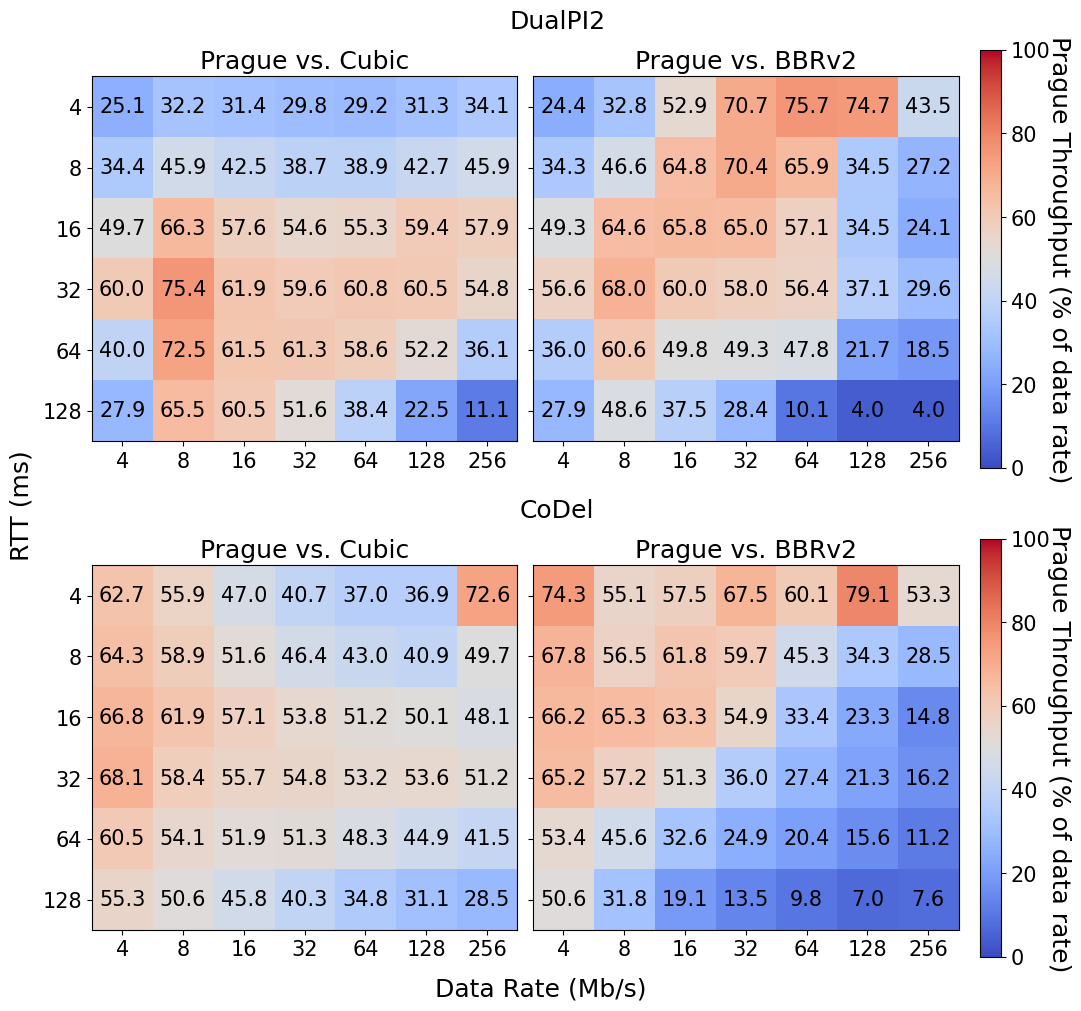

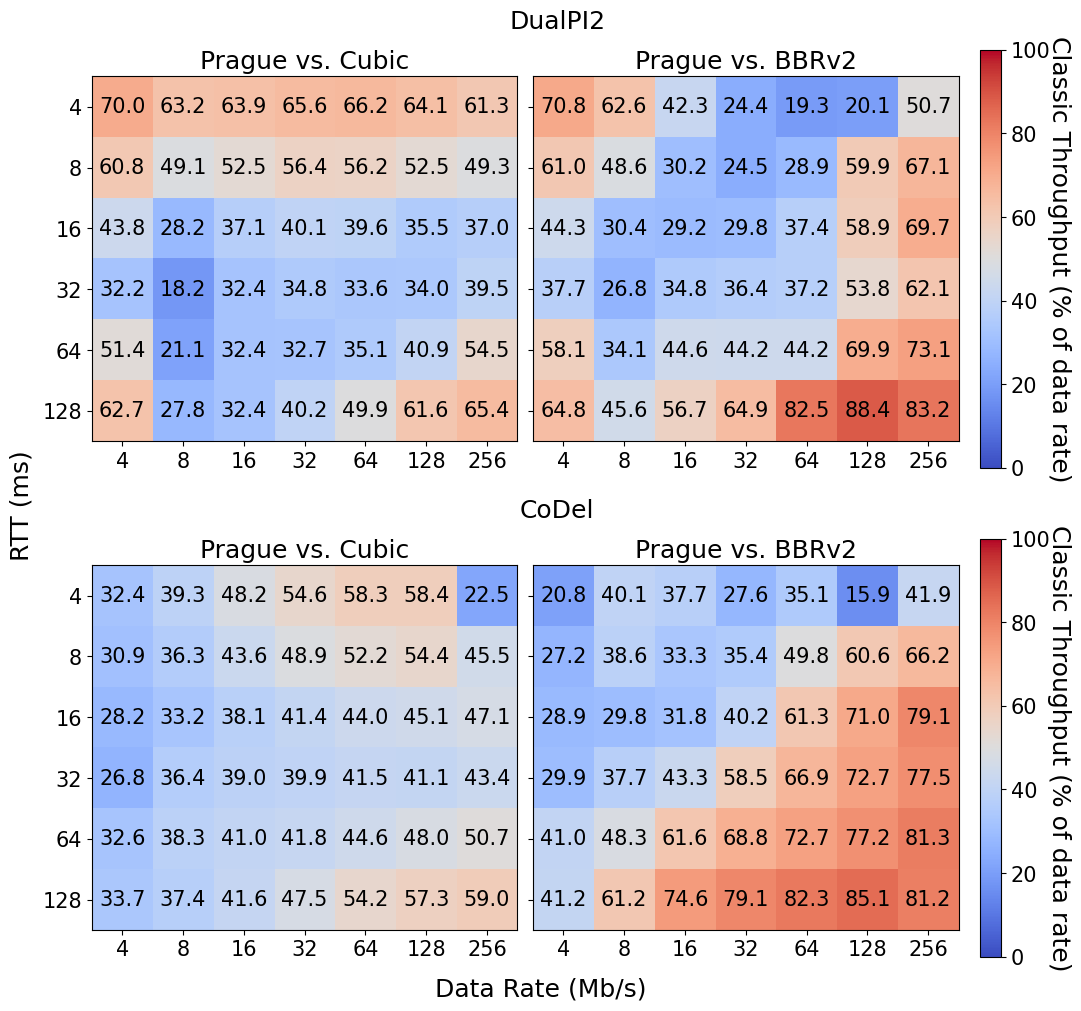

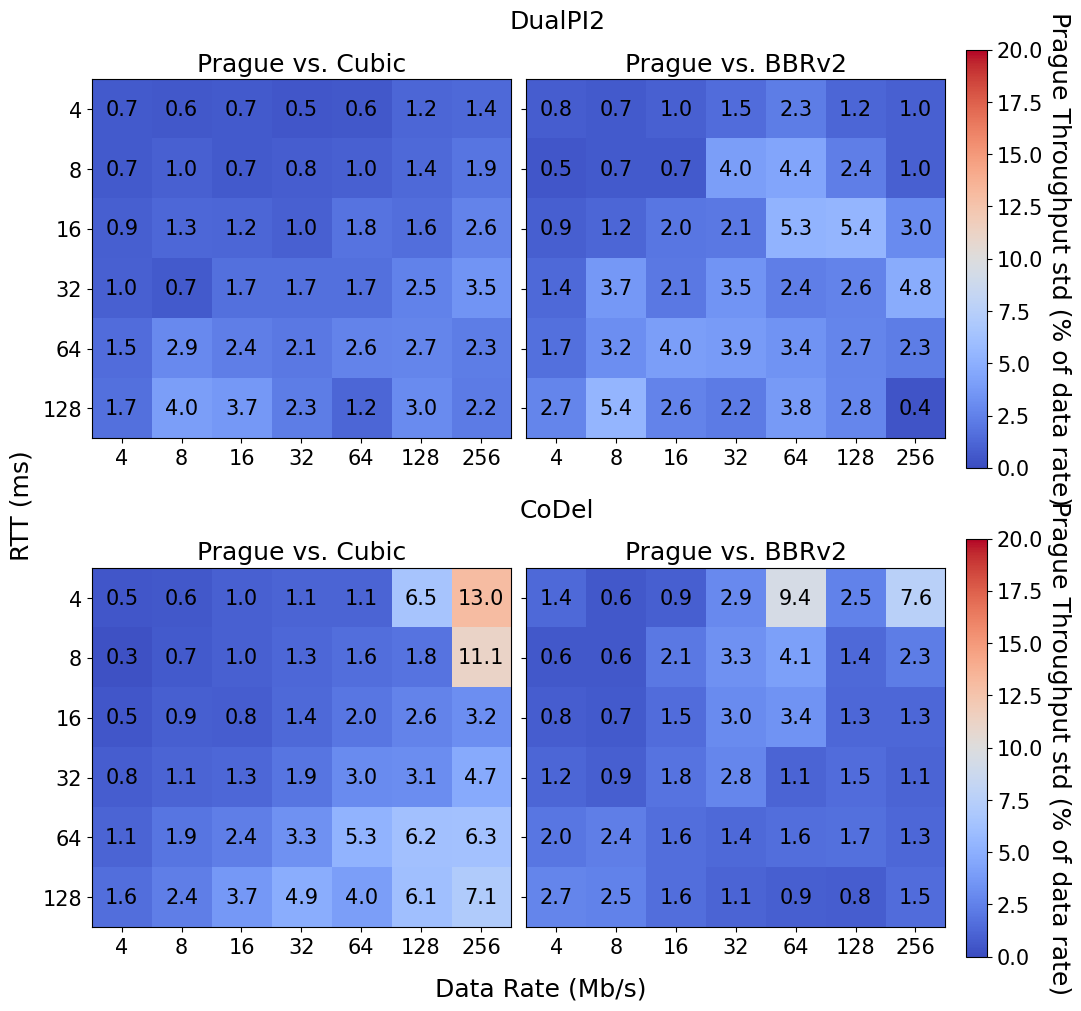

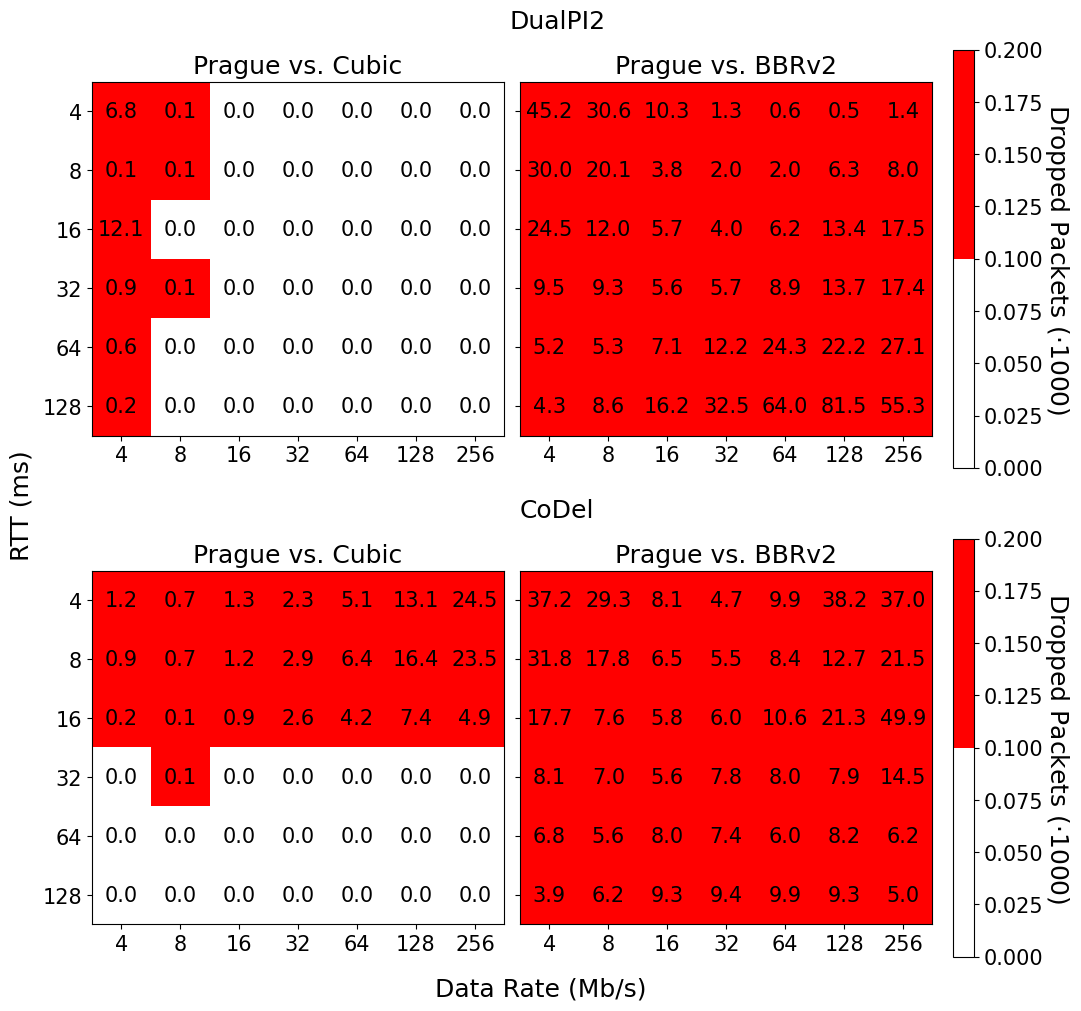

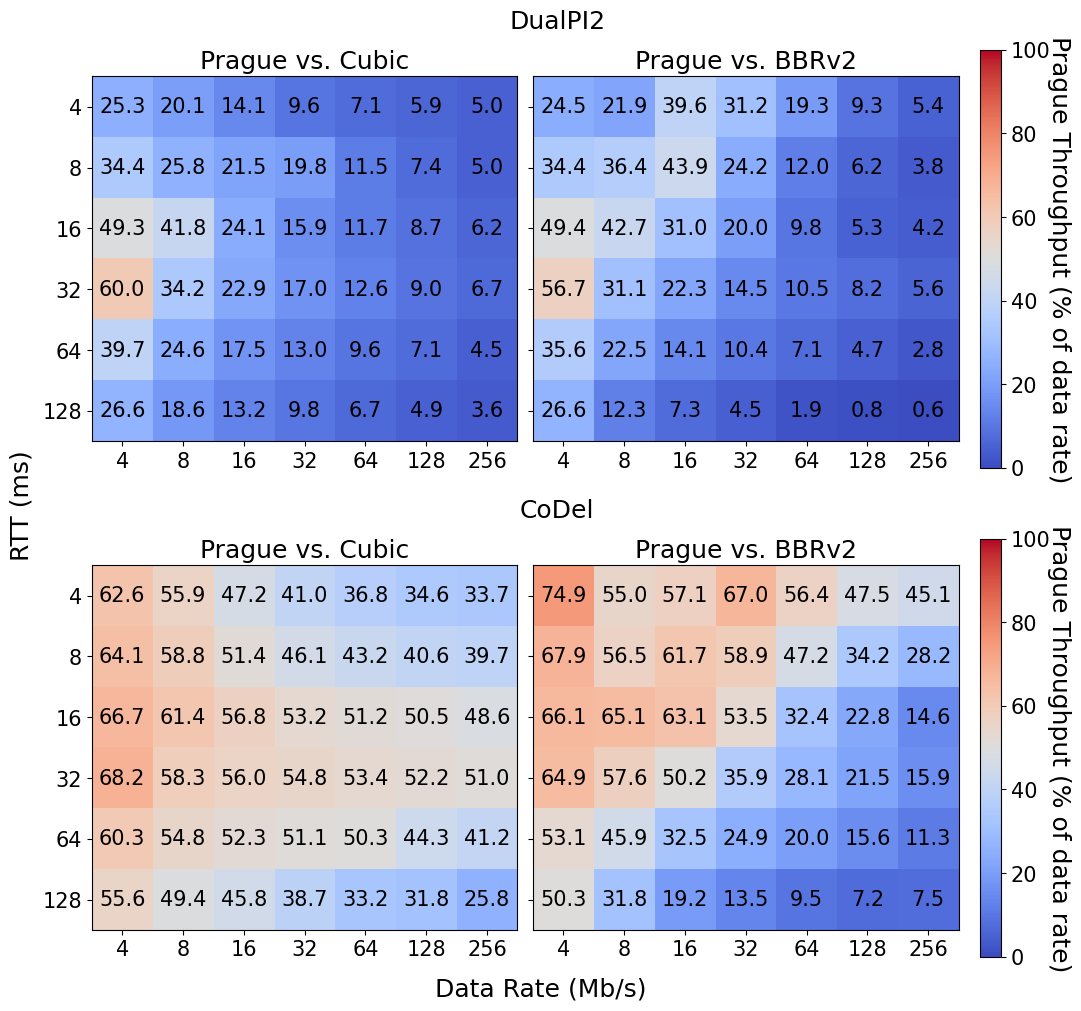

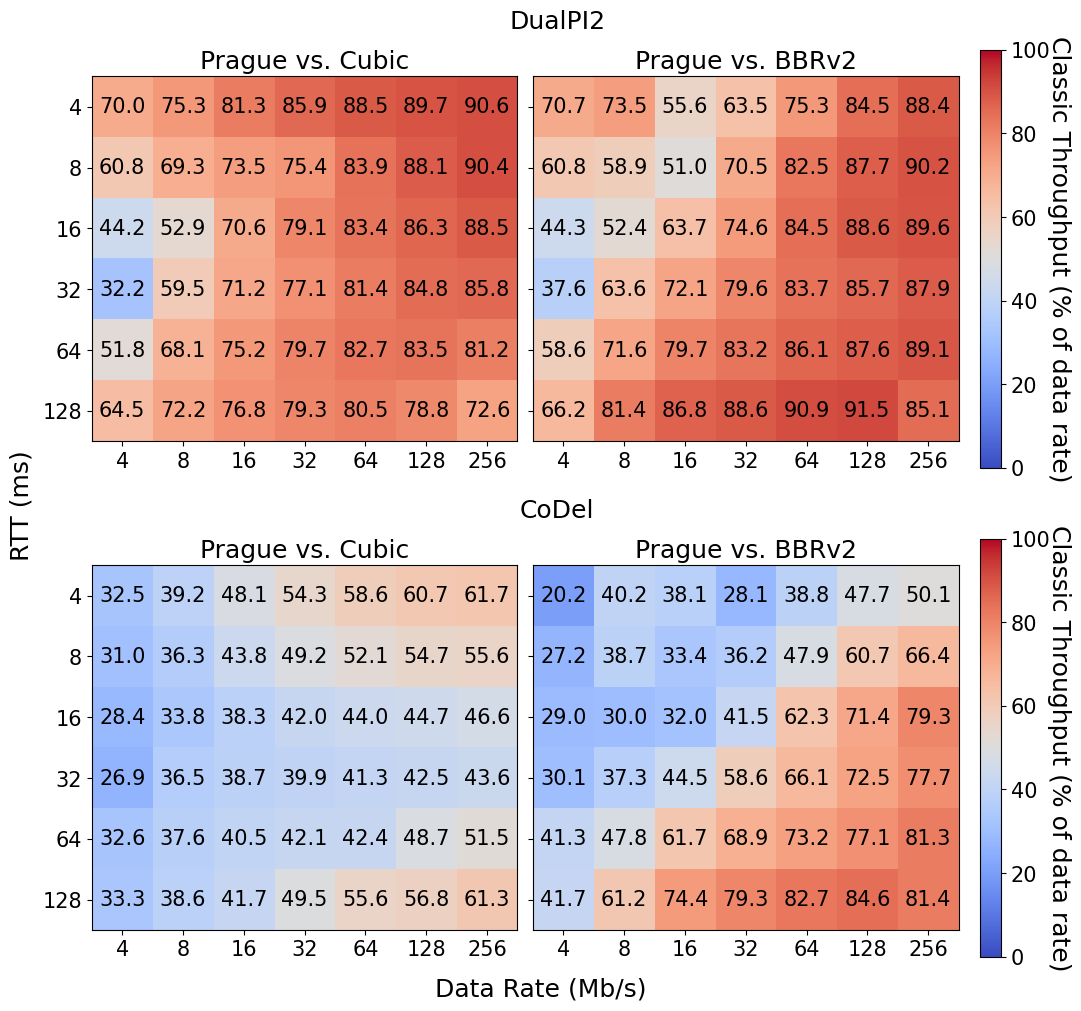

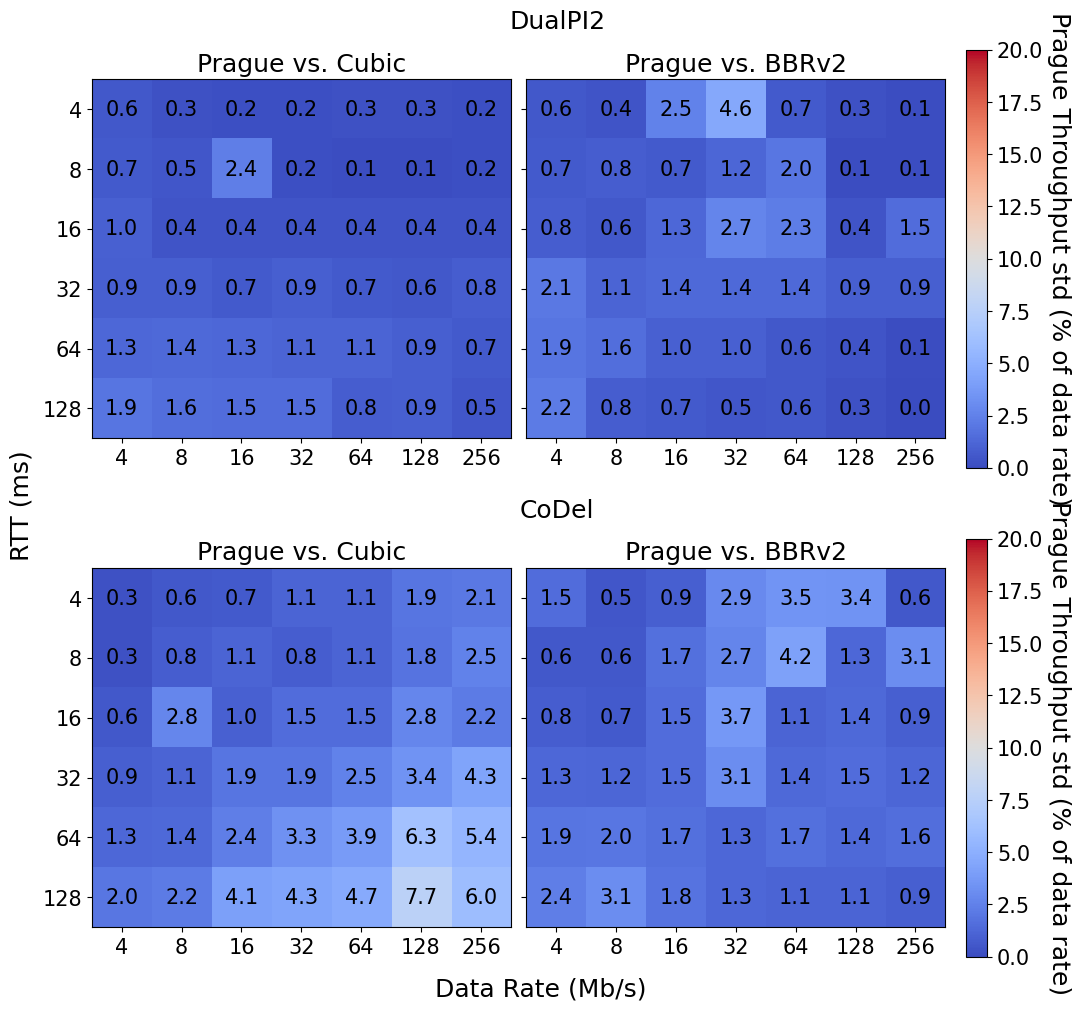

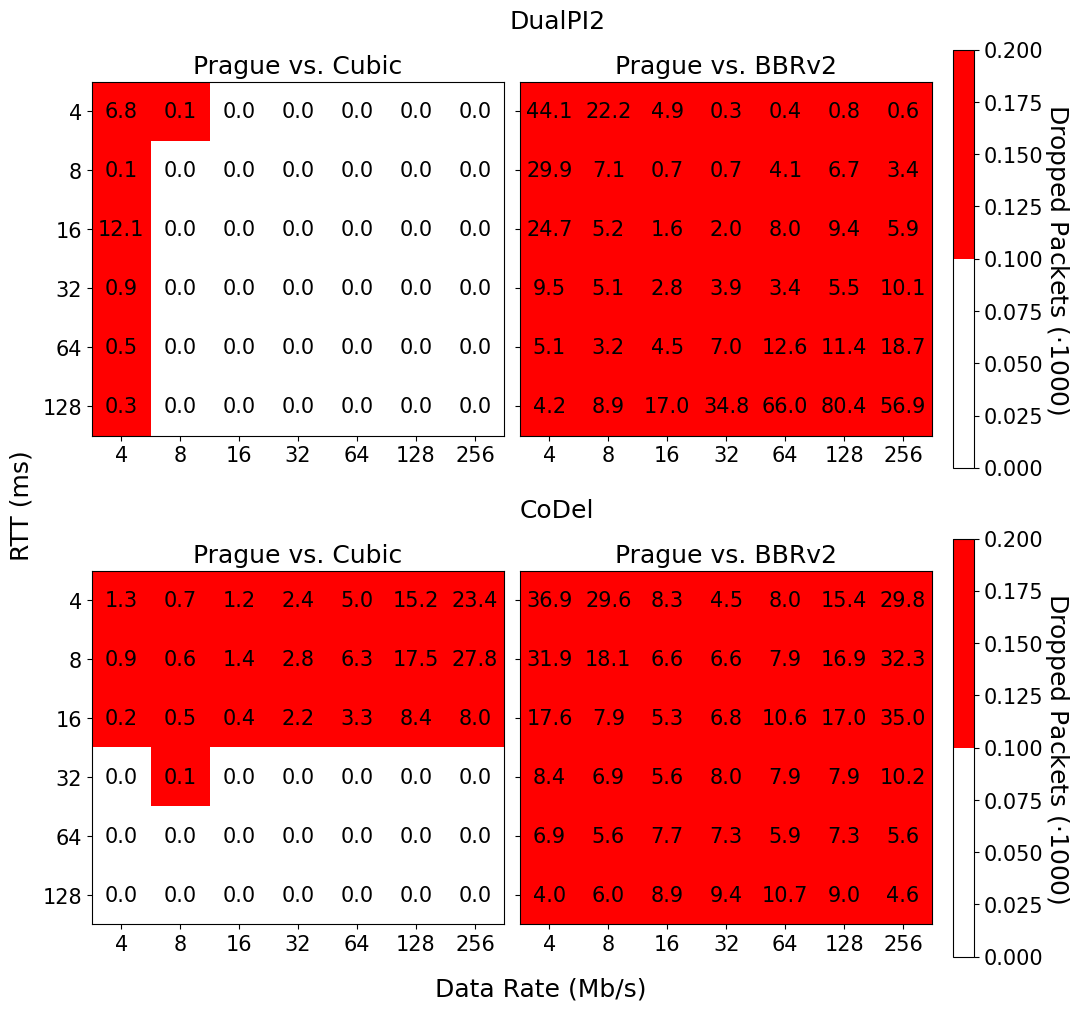

In [3]:
for kernel in KERNELS:
    plot_all(
        # We have to do two loc calls, or else pandas does not drop the levels
        df.loc[N_BDP, OMITS, KERNEL_NAME[kernel]]
        .loc[CLASSIC_CCAS]
        .reindex(
            pd.MultiIndex.from_product(
                [
                    CLASSIC_CCAS,
                    AQMS,
                    RTTS,
                    DATA_RATES,
                    list(range(REPETITIONS)),
                ],
                names=["classic_cca", "aqm", "rtt", "rate", "i"],
            )
        ),
        figsize=(10.7, 10),
        folder=f"images/extend/{kernel}",
        subfig_key="aqm",
        subplot_key="classic_cca",
        subplot_title_fun=lambda cca: f"Prague vs. {CCA_NAME[cca]}",
    )

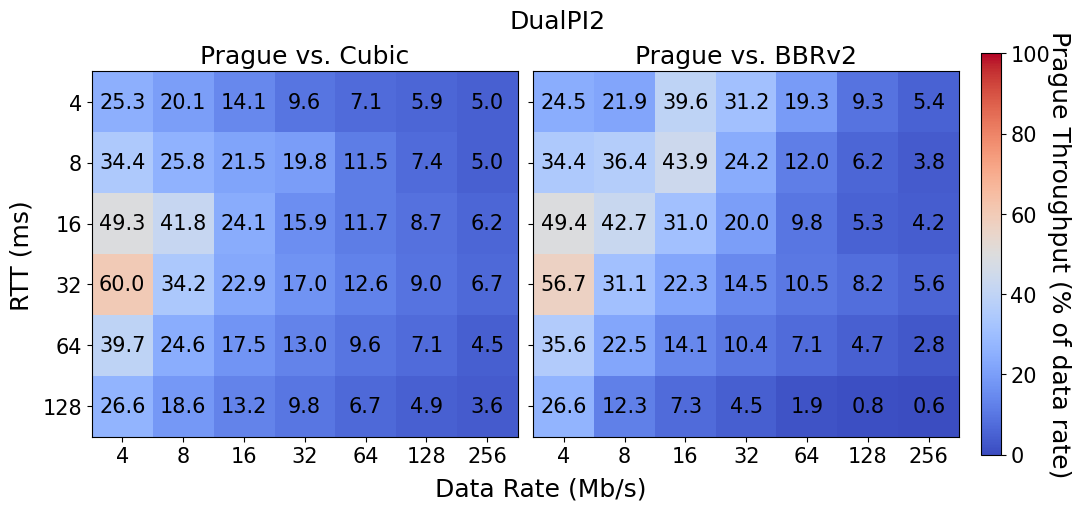

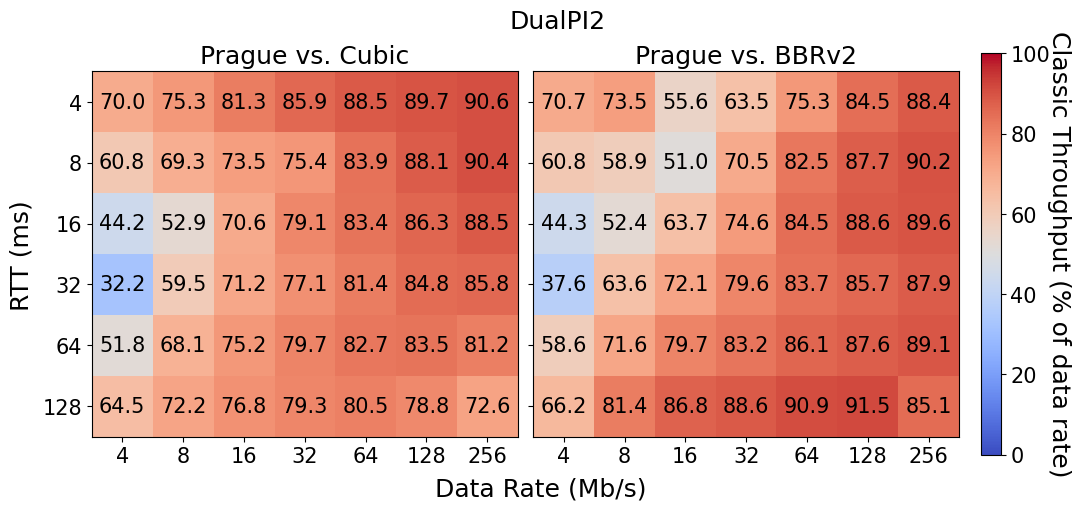

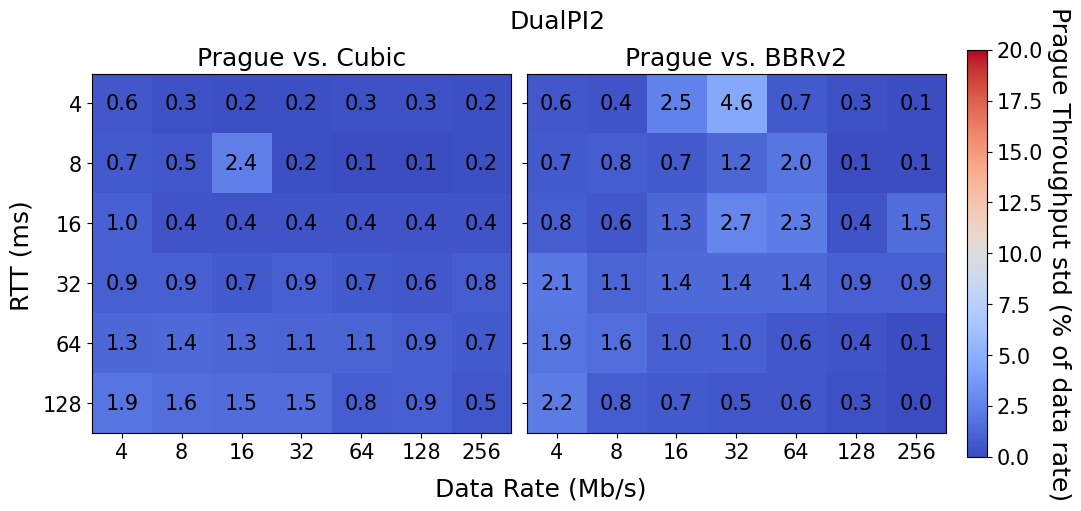

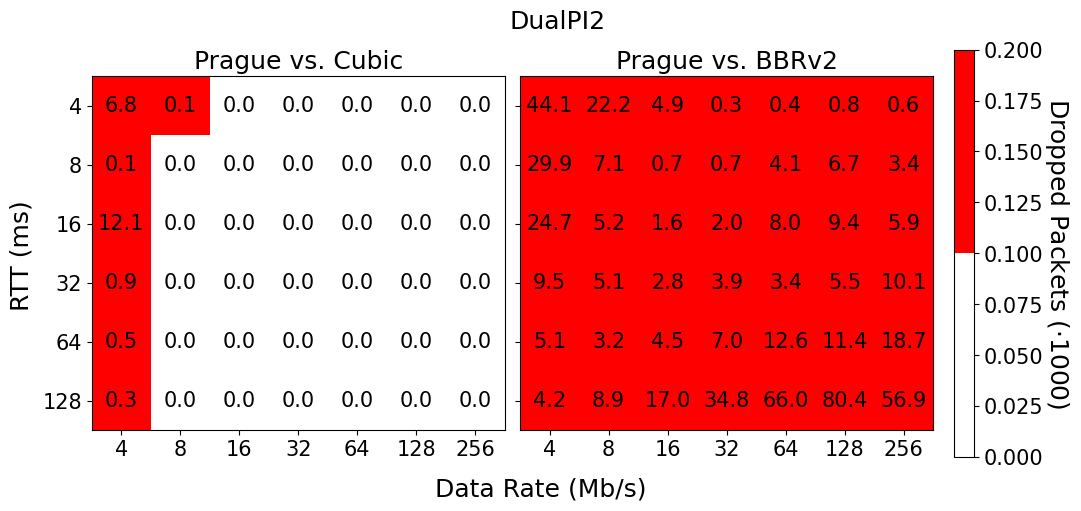

In [4]:
plot_all(
    df.loc[N_BDP, OMITS, KERNEL_NAME["unpatched"]]
    .loc[CLASSIC_CCAS]
    .xs("DualPI2", level="aqm", drop_level=False)
    .reindex(
        pd.MultiIndex.from_product(
            [
                CLASSIC_CCAS,
                ["DualPI2"],
                RTTS,
                DATA_RATES,
                list(range(REPETITIONS)),
            ],
            names=["classic_cca", "aqm", "rtt", "rate", "i"],
        )
    ),
    figsize=(10.7, 5),
    folder="images/extend/unpatched/DualPI2",
    subfig_key="aqm",
    subplot_key="classic_cca",
    subplot_title_fun=lambda cca: f"Prague vs. {CCA_NAME[cca]}",
)

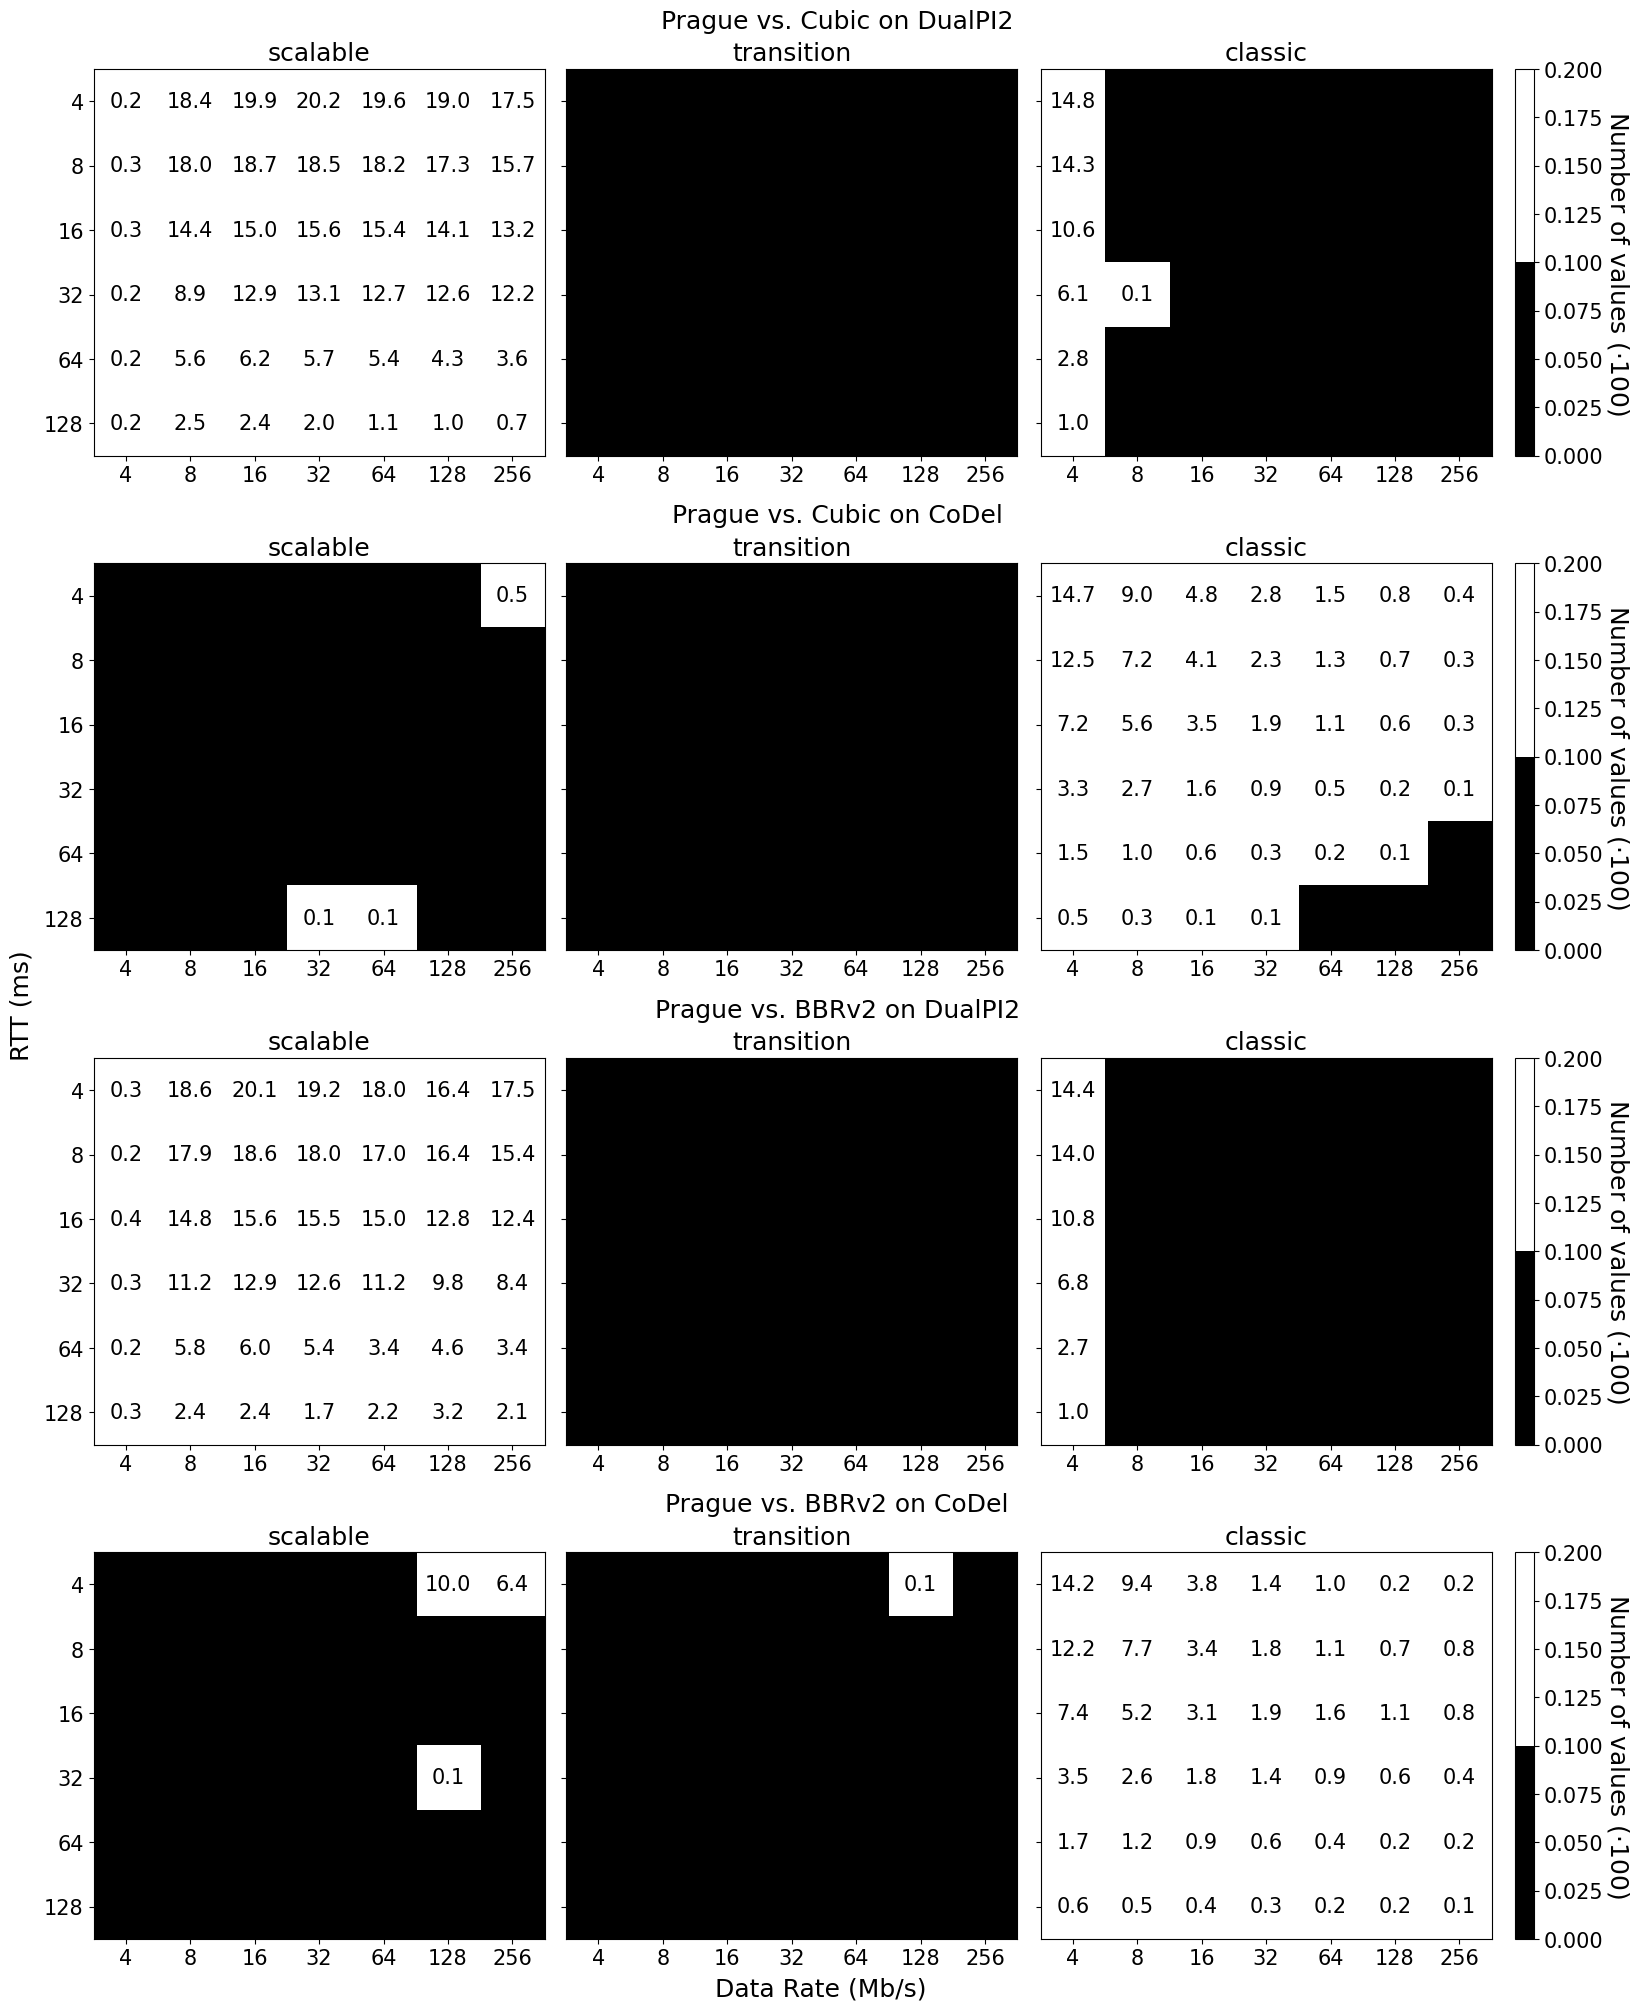

In [6]:
def transform_classic_cca(data):
    data = data.reshape([len(RTTS), len(DATA_RATES)])
    data /= 100
    data = np.round(data, decimals=1)
    return data


df_classic_cca = df.loc[N_BDP, OMITS, KERNEL_NAME["patched-trace"]].xs(31, level="i")[
    ["classic", "transition", "scalable"]
]
df_classic_cca.columns.name = "interval"
plot_matrix(
    df_classic_cca.set_index(
        pd.MultiIndex.from_tuples(
            [
                (f"Prague vs. {CCA_NAME[cca]} on {aqm}", *remainder)
                for cca, aqm, *remainder in df_classic_cca.index
            ],
            names=["title", *df_classic_cca.index.names[2:]],
        )
    )
    .stack()
    .reindex(
        pd.MultiIndex.from_product(
            [
                [
                    f"Prague vs. {CCA_NAME[cca]} on {aqm}"
                    for cca, aqm in itertools.product(CLASSIC_CCAS, AQMS)
                ],
                RTTS,
                DATA_RATES,
                INTERVALS,
            ],
            names=["title", "rtt", "rate", "interval"],
        )
    ),
    figsize=(16.3, 20),
    file="images/extend/patched/classic_ecn.pdf",
    subfig_key="title",
    subplot_key="interval",
    subplot_title_fun=lambda x: x,
    cbar_set_label_kwargs={
        "label": r"Number of values ($\cdot 100$)",
        "rotation": 270,
        "size": "large",
        "labelpad": 20,
    },
    data_transform=transform_classic_cca,
    imshow_kwargs={
        "cmap": colors.ListedColormap(["black", "white"]),
        "vmin": 0.0,
        "vmax": 0.2,
    },
)